In [3]:
# loading latent data
import numpy as np
import matplotlib.pyplot as plt

latent_data = np.load('Latent data/latentdata.npy')
labels = np.load('Latent data/simlabels.npy')

In [15]:
latent_data.shape

(63110, 16)

In [10]:
labels_vectors = np.zeros((len(labels), 10))
for i in range(len(labels)):
    labels_vectors[i][int(labels[i])] = 1

In [14]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(latent_data, labels_vectors, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [16]:
device = torch.device("mps")

In [25]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16, 20)
        self.fc2 = nn.Linear(20, 50)
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [34]:
X_train_tensor.unsqueeze(1), X_train_tensor

(tensor([[[11.8286,  0.3634, 12.8651,  ...,  3.9937, -0.0922,  1.3290]],
 
         [[16.0630,  5.4670, 15.0563,  ...,  8.6043,  2.6212,  2.7414]],
 
         [[13.1462,  2.5232, 16.1248,  ..., -1.2771,  1.6350,  2.9270]],
 
         ...,
 
         [[14.4786,  1.5711, 10.9022,  ...,  2.6328,  1.1034, -1.0217]],
 
         [[11.3747,  1.5125, 11.4312,  ..., -2.5474,  0.9596, -1.2985]],
 
         [[18.7119, -1.7933, 13.3022,  ..., -7.7200,  8.0668, -7.9135]]]),
 tensor([[11.8286,  0.3634, 12.8651,  ...,  3.9937, -0.0922,  1.3290],
         [16.0630,  5.4670, 15.0563,  ...,  8.6043,  2.6212,  2.7414],
         [13.1462,  2.5232, 16.1248,  ..., -1.2771,  1.6350,  2.9270],
         ...,
         [14.4786,  1.5711, 10.9022,  ...,  2.6328,  1.1034, -1.0217],
         [11.3747,  1.5125, 11.4312,  ..., -2.5474,  0.9596, -1.2985],
         [18.7119, -1.7933, 13.3022,  ..., -7.7200,  8.0668, -7.9135]]))

In [35]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [37]:
# Training loop
num_epochs = 800
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')

Epoch [10/800], Training Loss: 0.9586, Val Loss: 1.0390
Epoch [20/800], Training Loss: 0.9513, Val Loss: 0.9882
Epoch [30/800], Training Loss: 0.9482, Val Loss: 0.9751
Epoch [40/800], Training Loss: 0.9421, Val Loss: 0.9803
Epoch [50/800], Training Loss: 0.9456, Val Loss: 0.9949
Epoch [60/800], Training Loss: 0.9420, Val Loss: 0.9890
Epoch [70/800], Training Loss: 0.9357, Val Loss: 0.9773
Epoch [80/800], Training Loss: 0.9388, Val Loss: 0.9995
Epoch [90/800], Training Loss: 0.9364, Val Loss: 0.9926
Epoch [100/800], Training Loss: 0.9366, Val Loss: 0.9785
Epoch [110/800], Training Loss: 0.9353, Val Loss: 1.0049
Epoch [120/800], Training Loss: 0.9320, Val Loss: 0.9705
Epoch [130/800], Training Loss: 0.9304, Val Loss: 0.9938
Epoch [140/800], Training Loss: 0.9305, Val Loss: 0.9900
Epoch [150/800], Training Loss: 0.9326, Val Loss: 0.9728
Epoch [160/800], Training Loss: 0.9312, Val Loss: 0.9921
Epoch [170/800], Training Loss: 0.9306, Val Loss: 0.9935
Epoch [180/800], Training Loss: 0.9330, 

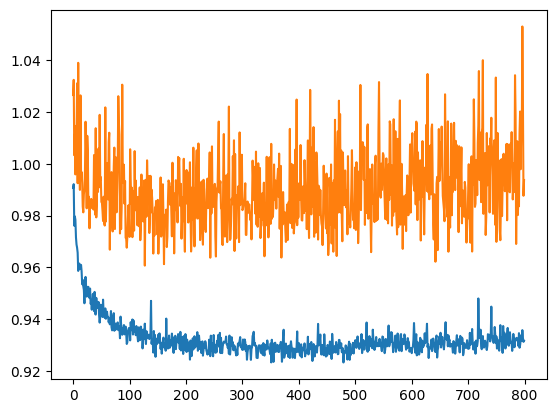

In [39]:
plt.plot(losses)
plt.plot(val_losses)

In [44]:
# test model accuracy
model.eval()
test_outputs = model(X_test_tensor.to(device))
_, test_preds = torch.max(test_outputs, 1)

# print percentage accuracy
correct = 0
total = 0
for i in range(len(y_test)):
    total += 1
    if test_preds[i] == torch.argmax(y_test_tensor[i]):
        correct += 1

In [46]:
correct/total

0.6686737442560609